<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/tcn_model/Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project — Electricity Load & Renewable Forecasting

This notebook contains the full workflow for our time series forecasting project:

- Loading and preparing the OPSD dataset
- Feature engineering
- Creating sliding windows
- Building LSTM, GRU, and Transformer models
- Training and evaluating models
- Comparing performance


# Data Pre-Processing

In [2]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex.csv to time_series_60min_singleindex.csv


In [3]:
import pandas as pd

df = pd.read_csv("time_series_60min_singleindex.csv")

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]

# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()

df.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,8336.0,NaN
2015-01-01 01:00:00+00:00,40135.0,8540.0,NaN
2015-01-01 02:00:00+00:00,39106.0,8552.0,NaN
2015-01-01 03:00:00+00:00,38765.0,8643.0,NaN


In [4]:
# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any NaNs that remain at the very start or end (edges)
df = df.ffill().bfill()

# Confirm everything is filled now
df.isna().sum()


,0
DE_load_actual_entsoe_transparency,0
DE_wind_onshore_generation_actual,0
DE_solar_generation_actual,0


In [5]:
# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

# SPLIT DATA (BEFORE SCALING)
# We define the split points using the raw data length
n = len(df)
train_size = int(n * 0.70)
val_size = int(n * 0.15)

# Split the raw DataFrame
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size : train_size + val_size]
test_df = df.iloc[train_size + val_size :]

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Check for outliers to determine what type of Scaling we should use
# target column
data = df['DE_load_actual_entsoe_transparency']

# If Z-Score outliers are > 0%, MinMax scaling might squash our 'normal' data
# Any point more than 3 Standard Deviations from the mean is considered an outlier
mean = np.mean(data)
std = np.std(data)
z_scores = (data - mean) / std
outliers_z = np.sum(np.abs(z_scores) > 3)
pct_z = (outliers_z / len(data)) * 100

print(f"Total Data Points: {len(data)}")
print(f"Outliers (Z-Score > 3): {outliers_z} ({pct_z:.2f}%)")

Total Data Points: 50401
Outliers (Z-Score > 3): 0 (0.00%)


In [7]:
from sklearn.preprocessing import StandardScaler

# SCALING (FIT ON TRAIN ONLY)
# Even though there are no outliers, we will use standard scalar to make the model
#robust for future unexpected outliers and to center the data for Relu activation function
scaler = StandardScaler()

# FIT only on Training data
scaler.fit(train_df)

# TRANSFORM all sets using the training statistics
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [8]:
# CREATE WINDOWS
def create_sliding_windows(data, window_size, target_idx):
    X_list, y_list = [], []
    for i in range(len(data) - window_size):
        # Input: Past 'window_size' steps
        X_list.append(data[i : i + window_size])
        # Target: The very next step (at index i + window_size)
        y_list.append(data[i + window_size, target_idx])
    return np.array(X_list), np.array(y_list)

# Define params
WINDOW_SIZE = 24
TARGET_COL_NAME = "DE_load_actual_entsoe_transparency"
target_idx = df.columns.get_loc(TARGET_COL_NAME)

# Create sets
X_train, y_train = create_sliding_windows(train_scaled, WINDOW_SIZE, target_idx)
X_val, y_val = create_sliding_windows(val_scaled, WINDOW_SIZE, target_idx)
X_test, y_test = create_sliding_windows(test_scaled, WINDOW_SIZE, target_idx)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (35256, 24, 6)
Test shape:  (7537, 24, 6)


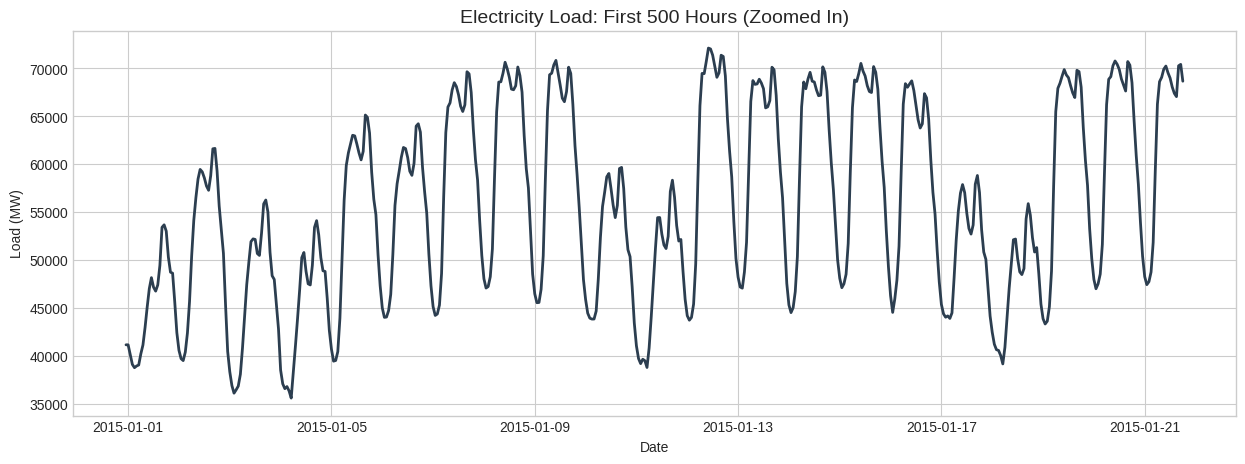

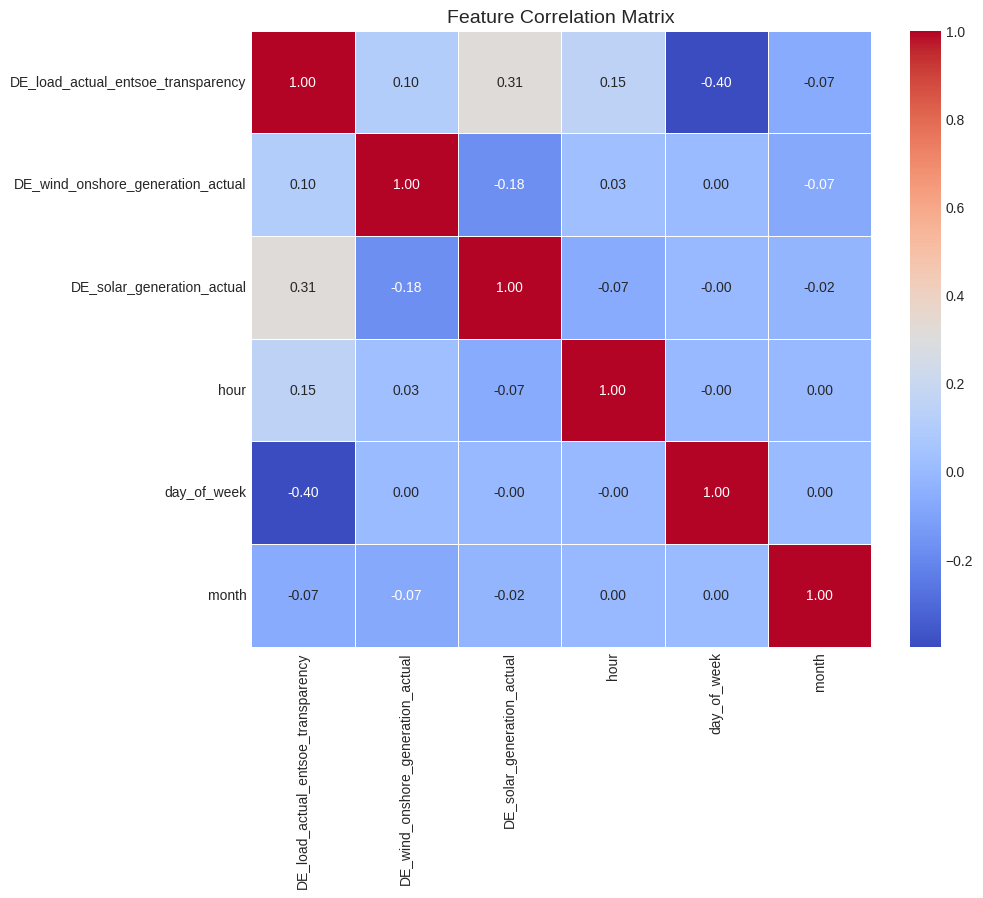

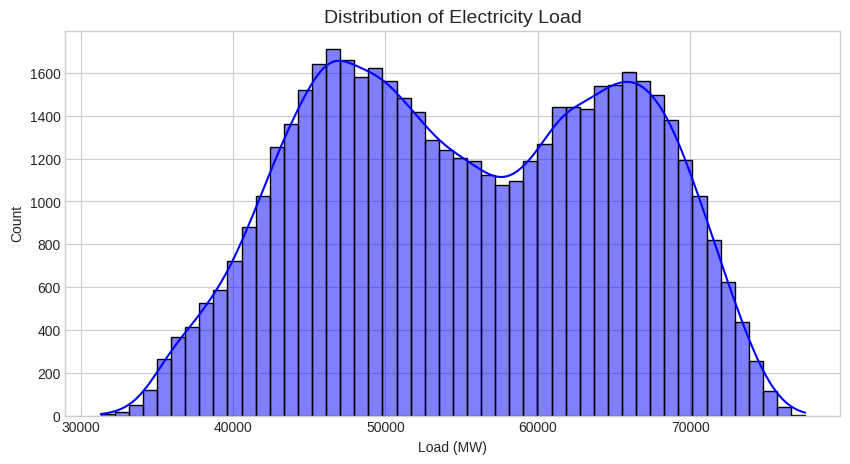

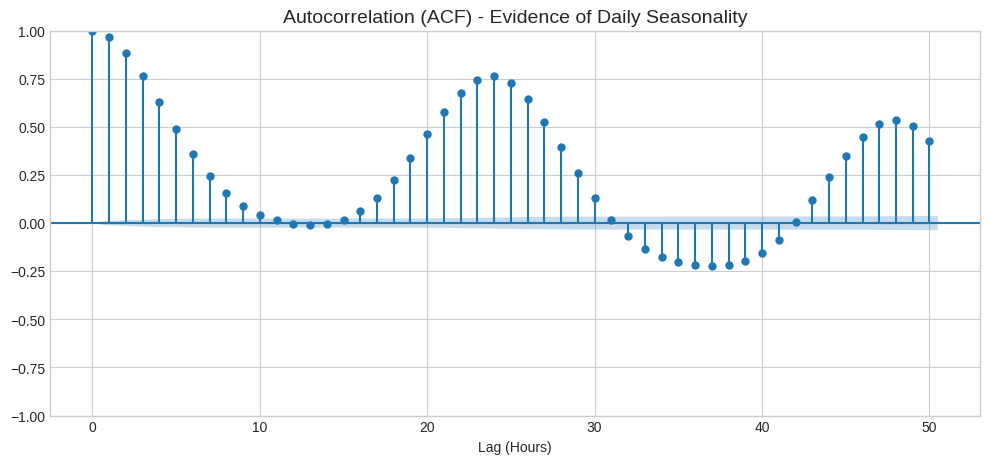

/tmp/ipython-input-3684477058.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='DE_load_actual_entsoe_transparency', data=df, palette="Blues")


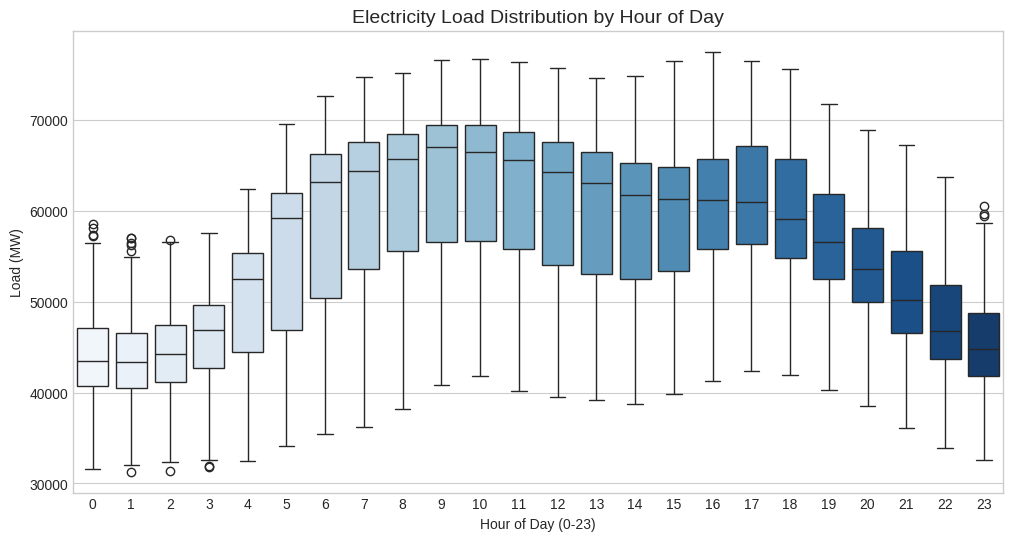

In [9]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Plot - Target Variable Over Time
plt.figure(figsize=(15, 5))
# Plot just the first 500 hours to make the pattern visible
plt.plot(df.index[:500], df['DE_load_actual_entsoe_transparency'][:500], color='#2c3e50', linewidth=2)
plt.title('Electricity Load: First 500 Hours (Zoomed In)', fontsize=14)
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.show()

# Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
# Calculate correlation matrix
corr = df.corr()
# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

# Distribution of the Target (Normality Check)
# Justifies using StandardScaler. If this looks like a Bell Curve, Standard Scaling is the mathematically correct choice.
plt.figure(figsize=(10, 5))
sns.histplot(df['DE_load_actual_entsoe_transparency'], kde=True, color='blue', bins=50)
plt.title('Distribution of Electricity Load', fontsize=14)
plt.xlabel('Load (MW)')
plt.show()

# Autocorrelation Plot (ACF)
# Justifies our Window Size. It shows how correlated the present is with the past.
# We will likely see a spike at lag 24, proving the daily cycle.
plt.figure(figsize=(12, 5))
plot_acf(df['DE_load_actual_entsoe_transparency'], lags=50, ax=plt.gca())
plt.title('Autocorrelation (ACF) - Evidence of Daily Seasonality', fontsize=14)
plt.xlabel('Lag (Hours)')
plt.show()

# Boxplot by Hour of Day
# Shows the "Shape" of a typical day.
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='DE_load_actual_entsoe_transparency', data=df, palette="Blues")
plt.title('Electricity Load Distribution by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Load (MW)')
plt.show()

## TCN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def tcn_residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):

    #Residual Block: [Dilated Conv -> BatchNormal -> RELU -> Dropout]x2

    shortcut = x

    # Branch 1
    x = layers.Conv1D(filters=filters,
                      kernel_size=kernel_size,
                      dilation_rate=dilation_rate,
                      padding='causal')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(rate=dropout_rate)(x)

    # Branch 2
    x = layers.Conv1D(filters=filters,
                      kernel_size=kernel_size,
                      dilation_rate=dilation_rate,
                      padding='causal')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(rate=dropout_rate)(x)

    # Dimension Matching - make sure output size is the same as the input size for the next block
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)

    # Add Residual
    res = layers.Add()([shortcut, x])
    return res

# Manual Builder
def build_tcn(input_shape, num_layers, filters, kernel_size, dropout):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Stack Blocks
    for i in range(num_layers):
        dilation = 2 ** i
        x = tcn_residual_block(x, filters, kernel_size, dilation, dropout)

    # Slicing (Last time step)
    x = layers.Lambda(lambda k: k[:, -1, :])(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Manual_TCN")

    # Compile with default learning rate for manual run
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae'])
    return model

# Builder function compatible with Keras Tuner
def build_tcn_hypermodel(hp):
    inputs = layers.Input(shape=(WINDOW_SIZE, X_train.shape[2]))
    x = inputs

    # HYPERPARAMETER 1: Number of Residual Blocks (Layers)
    # We search between 2 and 5 layers
    num_layers = hp.Int('num_layers', min_value=2, max_value=5, step=1)

    # HYPERPARAMETER 2: Filters (Width of network)
    # We search 32, 64, or 128 filters
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)

    # HYPERPARAMETER 3: Kernel Size
    # We try kernel sizes of 3 (standard) or 5 (larger receptive field)
    kernel_size = hp.Choice('kernel_size', values=[3, 5])

    # HYPERPARAMETER 4: Dropout Rate
    # We try 0.1, 0.2, 0.3
    dropout = hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1)

    # Stack Blocks dynamically
    for i in range(num_layers):
        dilation = 2 ** i
        x = tcn_residual_block(x, filters, kernel_size, dilation, dropout)

    # Slicing
    x = layers.Lambda(lambda k: k[:, -1, :])(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # HYPERPARAMETER 5: Learning Rate [cite: 138]
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

# Build Model
model = build_tcn(
    input_shape=(WINDOW_SIZE, X_train.shape[2]),
    num_layers=4,       # 4 layers to see back 24+ steps
    filters=64,
    kernel_size=3,
    dropout=0.2
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='mse', metrics=['mae'])

# TRAINING
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64, # Smaller batch size often generalizes better
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# EVALUATION
# Predict
preds_scaled = model.predict(X_test).flatten()

# Unscale
target_std = scaler.scale_[target_idx]
target_mean = scaler.mean_[target_idx]

preds_real = (preds_scaled * target_std) + target_mean
actual_real = (y_test * target_std) + target_mean

# Metrics
mae = np.mean(np.abs(preds_real - actual_real))
rmse = np.sqrt(np.mean((preds_real - actual_real)**2))

print(f"\nMAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")

# Plot Forecasting vs Real
plt.figure(figsize=(12, 6))
plt.plot(actual_real[:150], label='Actual', color='black', alpha=0.6)
plt.plot(preds_real[:150], label='Predicted', color='blue', linestyle='--')
plt.title(f"TCN Forecast | MAE: {mae:.2f} MW")
plt.legend()
plt.show()

#Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

#Plot Learning Curves

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss (MSE)
axes[0].plot(history.history['loss'], label='Train MSE', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val MSE', color='red', linewidth=2)
axes[0].set_title('Loss Curves (MSE)', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Metric (MAE)
axes[1].plot(history.history['mae'], label='Train MAE', color='blue', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', color='orange', linewidth=2)
axes[1].set_title('Metric Curves (MAE)', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True)

model.summary()

Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - loss: 1.4717 - mae: 0.3446 - val_loss: 0.0100 - val_mae: 0.0755 - learning_rate: 0.0100
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.0140 - mae: 0.0881 - val_loss: 0.0087 - val_mae: 0.0713 - learning_rate: 0.0100
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - loss: 0.0110 - mae: 0.0785 - val_loss: 0.0070 - val_mae: 0.0645 - learning_rate: 0.0100
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.0093 - mae: 0.0723 - val_loss: 0.0065 - val_mae: 0.0626 - learning_rate: 0.0100
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.0081 - mae: 0.0677 - val_loss: 0.0047 - val_mae: 0.0520 - learning_rate: 0.0100
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 0.0076 - mae: 0.0653 - val_loss: 0.0066 - val_mae: 0.0632 - learning_rate: 0.0100
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - loss: 0.0074 - mae: 0.0646 - val_loss: 0.0052 - val_mae: 0.0560 - learning_rate:

## Hyperparameter Optimization

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

# Instantiate the Tuner
tuner = kt.Hyperband(
    build_tcn_hypermodel,
    objective='val_loss',     # We want to minimize validation loss (MSE)
    max_epochs=20,            # Max epochs per trial
    factor=3,                 # Reduction factor for Hyperband
    directory='tcn_tuning',   # Folder to save results
    project_name='electricity_load_forecasting'
)

# Define Early Stopping to prevent wasting time on bad trials
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Starting Hyperparameter Search...")
# Run the search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[stop_early],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Optimal Num Layers: {best_hps.get('num_layers')}
Optimal Filters: {best_hps.get('filters')}
Optimal Kernel Size: {best_hps.get('kernel_size')}
Optimal Dropout: {best_hps.get('dropout')}
Optimal Learning Rate: {best_hps.get('learning_rate')}
""")

In [ ]:
# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train fully
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[stop_early],
    verbose=1
)

In [ ]:
# Evaluation of Best model
print("\n--- Evaluating Best Hyperparameter Model ---")

# Generate Predictions
best_preds_scaled = best_model.predict(X_test).flatten()

# Unscale Predictions (Convert back to MW)
# We use the mean and std deviation stored in the scaler
target_std = scaler.scale_[target_idx]
target_mean = scaler.mean_[target_idx]

best_preds_real = (best_preds_scaled * target_std) + target_mean
actual_real = (y_test * target_std) + target_mean

# Calculate Metrics
best_mae = np.mean(np.abs(best_preds_real - actual_real))
best_rmse = np.sqrt(np.mean((best_preds_real - actual_real)**2))

print(f"Optimized MAE:  {best_mae:.2f} MW")
print(f"Optimized RMSE: {best_rmse:.2f} MW")

# Plot Forecast vs Actual (First 150 Hours)
plt.figure(figsize=(12, 6))
plt.plot(actual_real[:150], label='Actual Load', color='black', alpha=0.6)
plt.plot(best_preds_real[:150], label='Optimized Prediction', color='green', linestyle='--', linewidth=2)
plt.title(f"Optimized TCN Forecast | MAE: {best_mae:.2f} MW", fontsize=14)
plt.xlabel('Time (Hours)')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

# Plot Training History (Loss & Metric Curves)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot A: Loss (MSE)
axes[0].plot(history.history['loss'], label='Train MSE', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val MSE', color='red', linewidth=2)
axes[0].set_title('Optimized Loss Curves (MSE)', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot B: Metric (MAE)
axes[1].plot(history.history['mae'], label='Train MAE', color='blue', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', color='orange', linewidth=2)
axes[1].set_title('Optimized Metric Curves (MAE)', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()